# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyClassifier
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    data_0 = pd.read_csv('geo_data_0.csv')
    data_1 = pd.read_csv('geo_data_1.csv')
    data_2 = pd.read_csv('geo_data_2.csv')    

### Посмотрим на общую информацию о датафреймах:

In [3]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [7]:
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [8]:
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Столбец id, во всех датафреймах, для нешего исследования не несет ни какой полезной информации, удалим его:

In [9]:
data_0.drop(['id'], axis=1, inplace=True) # удаляем столбец id во всех датафреймах.
data_1.drop(['id'], axis=1, inplace=True)
data_2.drop(['id'], axis=1, inplace=True)

In [10]:
data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [11]:
data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [12]:
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


### Пропуски:

In [13]:
data_0.isna().sum()

f0         0
f1         0
f2         0
product    0
dtype: int64

In [14]:
data_1.isna().sum()

f0         0
f1         0
f2         0
product    0
dtype: int64

In [15]:
data_2.isna().sum()

f0         0
f1         0
f2         0
product    0
dtype: int64

### Дубликаты:

In [16]:
data_0.duplicated().sum()

0

In [17]:
data_1.duplicated().sum()

0

In [18]:
data_2.duplicated().sum()

0

### Проверим наличие мультиколлинеарных признаков:

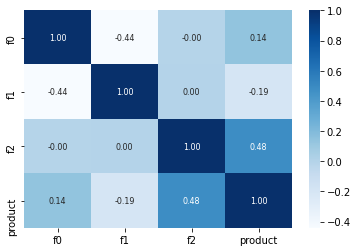

In [19]:
sns.heatmap(data_0.corr(), annot=True, cmap="Blues", fmt='.2f', annot_kws={'size':8});

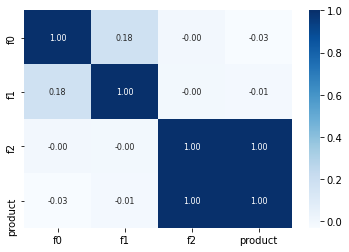

In [20]:
sns.heatmap(data_1.corr(), annot=True, cmap="Blues", fmt='.2f', annot_kws={'size':8});

Пара product-f2, датафрейма data_1, показывает сильную зависимость.

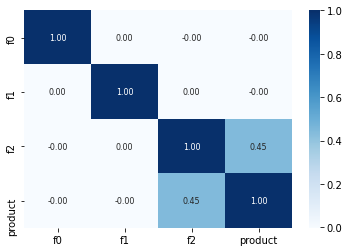

In [21]:
sns.heatmap(data_2.corr(), annot=True, cmap="Blues", fmt='.2f', annot_kws={'size':8});

***Итог:***
Мы провели первичное исследование и подготовку данных к обучению и проверки модели.

## Обучение и проверка модели

In [23]:
def sample(data):

    features = data.drop(['product'], axis=1)
    target = data['product']
    
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                                  random_state=12345)
    scaler  = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_test = scaler.transform(features_test)
    
    model = LinearRegression() # модель LinearRegression
    model.fit(features_train, target_train) # # обучаем модель на тренировочной выборке
    predictions = model.predict(features_test) # предсказания модели на валидационной выборке
    predictions = pd.Series(predictions)
    result = mean_squared_error(predictions, target_test)**0.5 # значение метрики RMSE на валидационной выборке
    
    print(f'RMSE модели: {result}. Средний предсказанный запас: {predictions.mean()}. Реальный средний запас: {target.mean()}.')
    return (predictions, target_test.reset_index(drop=True), result)

In [24]:
n = 1
for region in [data_0, data_1, data_2]:
    print(f'Регион {n}:')
    sample(region)
    print()
    n+=1

Регион 1:
RMSE модели: 37.5794217150813. Средний предсказанный запас: 92.59256778438035. Реальный средний запас: 92.50000000000001.

Регион 2:
RMSE модели: 0.893099286775617. Средний предсказанный запас: 68.728546895446. Реальный средний запас: 68.82500000000002.

Регион 3:
RMSE модели: 40.02970873393434. Средний предсказанный запас: 94.96504596800489. Реальный средний запас: 95.00000000000004.



In [25]:
predictions_1, target_1, result_1 = sample(data_0)
predictions_2, target_2, result_2 = sample(data_1)
predictions_3, target_3, result_3 = sample(data_2)

RMSE модели: 37.5794217150813. Средний предсказанный запас: 92.59256778438035. Реальный средний запас: 92.50000000000001.
RMSE модели: 0.893099286775617. Средний предсказанный запас: 68.728546895446. Реальный средний запас: 68.82500000000002.
RMSE модели: 40.02970873393434. Средний предсказанный запас: 94.96504596800489. Реальный средний запас: 95.00000000000004.


## Подготовка к расчёту прибыли

Переменные необходимые для подготовки к расчету прибыли:

In [27]:
BUDGET = 10e9
INCOME_ONE_BARREL = 450
INCOME_THOUSAND_BARREL = INCOME_ONE_BARREL * 1000
RESEARCHED_SPOTS = 500
TOP_SPOTS = 200

In [28]:
def revenue(predictions, target): # функция для подсчета прибыли
    pred_sorted = predictions.sort_values(ascending=False)
    selected = target[pred_sorted.index][:200]
    return INCOME_THOUSAND_BARREL * selected.sum() - BUDGET

При помощи наших переменных расчитаем:
 * Среднюю прибыль на лучшую точку
 * Средний объём для безубыточной добычи на регион

Исходя из бюджета на один регион в 10 млрд.руб. и то что отобраны будут для разработки всего 200 скважин то:
* безубыточная добыча на одну скважину в регионе равна: бюджет / колличество скважин;
* Средний объём для безубыточной добычи на регион равен: бюджет / цену 1000 баррелей.

In [29]:
break_even_production = BUDGET / TOP_SPOTS
average_breakeven_volume = BUDGET / INCOME_THOUSAND_BARREL
print(f'Среднюю прибыль на лучшую точку:{break_even_production} руб.')
print('Средний объём для безубыточной добычи на регион: {0:.0f} тыс. баррелей'.format(average_breakeven_volume))
print('Средний объем запасов нефти в скважине для безубыточной добычи:', np.ceil(average_breakeven_volume/200))

Среднюю прибыль на лучшую точку:50000000.0 руб.
Средний объём для безубыточной добычи на регион: 22222 тыс. баррелей
Средний объем запасов нефти в скважине для безубыточной добычи: 112.0


## Расчёт прибыли и рисков 

Напишем функцию при помощи которой найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. 

In [34]:
state = np.random.RandomState(12345)

def profit_and_risk(target, predictions):
    
    values = []
    
    for i in range(1000):
        target_subsample = target.sample(500, replace=True, random_state=state)
        probs_subsample = predictions[target_subsample.index]
        rev = revenue(target_subsample,probs_subsample)
        values.append(rev)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()
    risk = st.percentileofscore(values, 0)
    
    return ((lower, upper), mean, risk)        

При помощи цикла выведем на экран все необходимые нам данные.

In [35]:
n = 1
for predictions, target in zip([predictions_1, predictions_2, predictions_3], 
                         [target_1, target_2, target_3]):
    interval, mean, risk = profit_and_risk(predictions, target)
    print(f'Регион {n}:')
    print(f'Средняя выручка: {mean}руб.')
    print(f'95% Доверительный интервал: {interval}')
    print(f'Риск убытков: {risk}%')    
    print()
    n+=1

Регион 1:
Средняя выручка: 425938526.91059244руб.
95% Доверительный интервал: (-102090094.83793654, 947976353.3583689)
Риск убытков: 6.0%

Регион 2:
Средняя выручка: 518259493.6973249руб.
95% Доверительный интервал: (128123231.43308444, 953612982.0669085)
Риск убытков: 0.3%

Регион 3:
Средняя выручка: 420194005.3440501руб.
95% Доверительный интервал: (-115852609.16001143, 989629939.8445739)
Риск убытков: 6.2%



## Выводы

Мы подготовили данные, провели первичный анализ, проверили данные на наличие пропусков и дубликатов. Разделили данные на выборки (тренировочную и тестовую), обучили и проверили модель линейной регрессии.

Исходя из проделанной работы, можно сделать вывод о том что:
* 2 из 3 региона имеют 6% риск убыточности
* Регион 2 (data_1) на данный момент является самым перспективным, для дальнейшей разработки